### Shopper intent prediction from clickstream e‑commerce data with minimal browsing information

#### Data Structure

The dataset is provided as one big text file (.csv), inside a zip archive containing an additional copy of the Terms And Conditions. The final dataset contains 5,433,611 individual events, and it is the first dataset of this kind to be released to the research community. A sample file is included in this repository, showcasing the data structure.


<table>
<thead>
<tr>
<th>Field</th>
<th>Type</th>
<th>Description</th>
</tr>
</thead>
<tbody>
<tr>
<td>session_id_hash</td>
<td>string</td>
<td>Hashed identifier of the shopping session. A session groups together events that are at most 30 minutes apart: if the same user comes back to the target website after 31 minutes from the last interaction, a new session identifier is assigned.</td>
</tr>
<tr>
<td>event_type</td>
<td>enum</td>
<td>The type of event according to the <a href="https://developers.google.com/analytics/devguides/collection/protocol/v1" rel="nofollow">Google Protocol</a>, one of { <em>pageview</em> , <em>event</em> }; for example, an <em>add</em> event can happen on a page load, or as a stand-alone event.</td>
</tr>
<tr>
<td>product_action</td>
<td>enum</td>
<td>One of { <em>detail</em>, <em>add</em>, <em>purchase</em>, <em>remove</em>, <em>click</em> }. If the field is empty, the event is a simple page view (e.g. the <code>FAQ</code> page) without associated products.</td>
</tr>
<tr>
<td>product_skus_hash</td>
<td>string</td>
<td>If the event is a <em>product</em> event, hashed identifiers of all products in the event (e.g. all the products in a transaction), pipe separated.</td>
</tr>
<tr>
<td>server_timestamp_epoch_ms</td>
<td>int</td>
<td>Epoch time, in milliseconds. The epoch time has been shifted in time to further anonymize the data.</td>
</tr>
<tr>
<td>hashed_url</td>
<td>string</td>
<td>Hashed url of the current web page.</td>
</tr>
</tbody>
</table>

In [14]:
import pandas as pd

In [15]:
data_path = 'release_10_23_2020.csv'
df = pd.read_csv(data_path)

In [16]:
df.shape

(5433611, 6)

In [17]:
df.dtypes

,0
session_id_hash,object
event_type,object
product_action,object
product_skus_hash,object
server_timestamp_epoch_ms,int64
hashed_url,object


In [18]:
df.head()

,session_id_hash,event_type,product_action,product_skus_hash,server_timestamp_epoch_ms,hashed_url
0,00000005c19449b57d8d05dfc8b5474be0654032,pageview,NaN,NaN,1544469996111,da99729886aff70a02733b6cd69ee7df35622d9302347e...
1,00006a0ada94a5186163a25e9ed9c94481c820d9,pageview,NaN,NaN,1545737959865,e2f7e0cee4272e804f0d323a3513dd01716a5a40ab9abf...
2,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,NaN,NaN,1544908835402,ea7b2493be61ff454f8cce412f9dc281e605daec8c43b5...
3,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,NaN,NaN,1544908847263,ea7b2493be61ff454f8cce412f9dc281e605daec8c43b5...
4,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,detail,90add4dd072e160034e98ddea257e0b59441eae00d8955...,1544909035879,8fa1ecf31ececb27ebe9c529966f3d1f907542fe138d5d...


In [19]:
df.groupby('event_type')['product_action'].value_counts(dropna=False)

event_type  product_action
event       add                743363
            click               69831
            remove              51512
            NaN                  3652
pageview    NaN               2915137
            detail            1640190
            purchase             9926
Name: count, dtype: int64

### 1. Symbolization & Sessionization
- dataset into symbolic trajectories with minimal information
- predictability of user intent based purely on the sequence of their actions
- Demonstrating that prediction is possible even with minimal information

1 = page view (any page load with no specific product action), \
2 = product detail view, \
3 = add to cart, \
4 = remove from cart, \
5 = purchase, \
6 = click on a search result.


#### 1.2 Map each event to the corresponding symbol.


In [20]:
# product_action is one of {detail, add, remove, purchase, click} or empty (for simple page views).
mapping = {'detail': 2, 'add': 3, 'remove': 4, 'purchase': 5, 'click': 6}
df['symbol'] = df['product_action'].map(mapping)
# empty product_action -> NaN -> fill as 1 (page view)
df['symbol'] = df['symbol'].fillna(1).astype(int)

In [21]:
df[['session_id_hash', 'event_type', 'product_action', 'server_timestamp_epoch_ms', 'symbol']].head()

,session_id_hash,event_type,product_action,server_timestamp_epoch_ms,symbol
0,00000005c19449b57d8d05dfc8b5474be0654032,pageview,NaN,1544469996111,1
1,00006a0ada94a5186163a25e9ed9c94481c820d9,pageview,NaN,1545737959865,1
2,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,NaN,1544908835402,1
3,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,NaN,1544908847263,1
4,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,detail,1544909035879,2


#### 1.3 Group events by session to form sequences

In [22]:
# Ensure events are in chronological order within each session
df = df.sort_values(['session_id_hash', 'server_timestamp_epoch_ms'])

# Group events by session to form sequences
sessions = df.groupby('session_id_hash')['symbol'].agg(list)

In [23]:
sessions.head()

,symbol
session_id_hash,
00000005c19449b57d8d05dfc8b5474be0654032,[1]
00006a0ada94a5186163a25e9ed9c94481c820d9,[1]
00007d15aeb741b3cdd873cb3933351d699cc320,"[1, 1, 2, 1, 2, 1, 2]"
0000c49d1359c87f112285d63a9fc0d4c50f73b4,"[1, 1, 1]"
0001135282dbaf0e734345212ea6f8da9f5b66ed,[1]


#### 2. Labeling and Trimming
- The conversion class (C) is assigned to all trajectories that contain at least one Purchase event
- All trajectories belonging to class C are trimmed
- This trimming process keeps only the initial part of the trajectory that occurs before the first Purchase event
- The non-conversion class (NC) encompasses all other trajectories
- Filter out sequences too short or too long

In [25]:
sequences = []  # list of symbol sequences for each session
labels = []     # corresponding labels (1 for conversion, 0 for non-conversion)
for session_id, seq in sessions.items():
    # Determine label: 1 if purchase (5) is in the sequence, 0 otherwise
    label = 1 if 5 in seq else 0
    if label == 1:
        # Trim sequence at the first purchase (do not include the purchase event)
        first_purchase_idx = seq.index(5)
        seq = seq[:first_purchase_idx]
    # Filter out sequences too short or too long
    if len(seq) >= 5 and len(seq) <= 155:
        sequences.append(seq)
        labels.append(label)

print(f"Total sessions after preprocessing: {len(sequences)}")
print(f"Conversions: {sum(labels)} ({100*sum(labels)/len(labels):.2f}%); Non-conversions: {len(labels)-sum(labels)}")

Total sessions after preprocessing: 203084
Conversions: 8329 (4.10%); Non-conversions: 194755


#### Trejectories for Sessions and Labels

In [26]:
print(sequences[:5])
print(labels[:5])

[[1, 1, 2, 1, 2, 1, 2], [1, 1, 1, 1, 1, 1, 2, 6, 1, 2, 1, 1, 1, 1, 1, 1], [1, 1, 2, 6, 1], [1, 1, 2, 1, 2, 1, 2, 1], [1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2]]
[0, 0, 0, 0, 0]


#### 2.1 Plot C, and NC trejectories for 2 sessions

In [27]:
import matplotlib.pyplot as plt

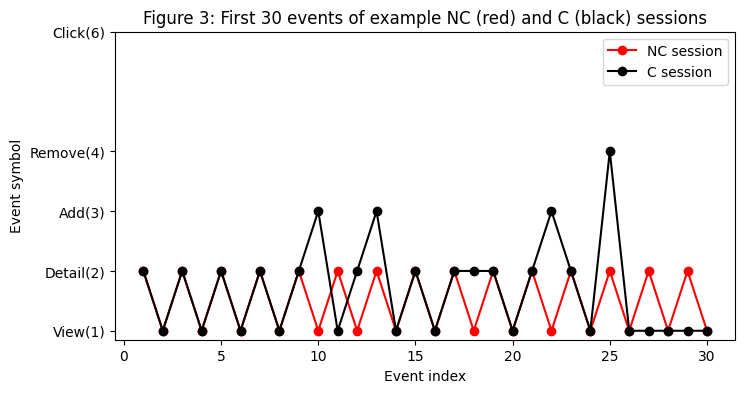

In [28]:
# Find first NC (label 0) and C (label 1) sequences with at least 30 events
nc_seq = next(seq for seq, label in zip(sequences, labels) if label == 0 and len(seq) >= 30)[:30]
c_seq = next(seq for seq, label in zip(sequences, labels) if label == 1 and len(seq) >= 30)[:30]

# Plotting the two trajectories
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(nc_seq) + 1), nc_seq, color='red', marker='o', label='NC session')
plt.plot(range(1, len(c_seq) + 1), c_seq, color='black', marker='o', label='C session')

plt.title('Figure 3: First 30 events of example NC (red) and C (black) sessions')
plt.xlabel('Event index')
plt.ylabel('Event symbol')
plt.yticks([1, 2, 3, 4, 6], ['View(1)', 'Detail(2)', 'Add(3)', 'Remove(4)', 'Click(6)'])
plt.legend(loc='upper right')
plt.show()

### 3. Feature Engineering (Hand-Crafted Features)

#### 3.1 K-grams
The most straightforward feature that one can extract from a symbolized time series is the joint
distribution of symbols. A k-grams is defned as a block of k consecutive symbols. As such, isolated symbols are
1-g, whereas blocks of two consecutive symbols such as ‘11’, ‘12’, ‘13’, ..., ‘66’ are examples of 2-g. Notice that the
symbol ‘5’ associated to the Purchase action will not appear in both 1- and 2-g by construction

Example: Symbolic trejectory (1, 2, 1, 3, 2)

<b>1-grams</b> (k=1) are the individual symbols in the sequence \
(1) - appears twice (2) - appears twice (3) - appear once
-  normalized frequency histogram of 1-grams is labeled P(s)
- P(1) = 2/5, P(2) = 2/5, and P(3) = 1/5


<b>2-gram</b> \

(1, 2) (Page view, Detail view), (2, 1) (Detail view, Page view), (1, 3) (Page view, Add to cart), (3, 2), (Add to cart, Detail view)
- there are 4 2-grams in a trejectory of 5
- normalized frequencies P(1, 2), p(2, 1), P(1, 3), P(3,2 ) = 1/4

Why use k-grams? \
- K-grams provide a straightforward way to extract features from the sequential clickstream data
- Pattern Identification: The frequency of specific k-grams can reveal recurring patterns in user navigation
- Quantifying Symbol Co-occurrence: K-grams capture the joint distribution of consecutive actions. This allows the models to learn not just about the individual actions but also about how they tend to follow each other.


#### 3.2 Horizontal Visibility Graph

A time series is transformed into a graph where each data point is a node. An edge exists between two nodes i and j if all the data points between them are smaller than both x_i and x_j. This method uses graph theory to analyze the structure of time series

Sequential HVG Motifs (HVGm): HVGms of order p are identified by taking a sliding window of size p along the sequence of nodes in the HVG (ordered by time). For each window, the subgraph formed by the p nodes and the edges only between these nodes is considered a sequential HVGm. The source primarily focuses on HVGms of order 4 (the lowest nontrivial order for sequential HVG motifs is p = 4). Figure 7 in the source enumerates all 6 possible motifs of order 4 for discrete-valued time series

Example: Enumerate all possible motifs of order p = 4 (only 6
possibilities).

- View-View-Detail-View (1121) is an example of a Z1 motif.
- Add-View-View-Remove (3114) is an example of a Z2 motif.
- Add-View-Add-Detail (3132) is an example of a Z3 motif

[The authors’ approach to identifying Z1–Z3 motifs is based on transforming the symbolic clickstream into a horizontal visibility graph (HVG) and then extracting local “motifs” by sliding a fixed‐size window over the graph’s natural (time) ordering.]

Why HVGms are used?
- Capturing Higher-Order Patterns in Short Sequences: E-commerce clickstream trajectories can be relatively short. HVGms are designed to extract more complex, higher-order patterns from these short samples
- Computational Efficiency: Despite capturing higher-order patterns, calculating HVGm statistics is computationally efficient
- Combinatorial Metric: HVGms provide a combinatorial way to characterize the dynamics of user interactions on the e-commerce website. The abundance of different motifs can reveal underlying patterns in browsing behavior that might be indicative of purchase intent
- Complementary to Other Features: The study shows that combining HVGm features with traditional k-gram statistics can lead to accurate classifications of user intent
- Potential for Real-time Applications: The computational efficiency of HVGm extraction makes them suitable for real-time analysis and prediction of customer behavior during their browsing session

Entropy of the HVGm profile?
- Entropy of the HVGm Profile: The authors compute the entropy of the HVGm profile ($h_Z$) to quantify the heterogeneity of a motif profile
- A higher value of $h_Z$ indicates that the different motifs appear more evenly represented in the time series. This suggests a richer variety of local structural patterns in the data
- A lower value of $h_Z$ suggests that a particular motif is overrepresented compared to others, indicating less diversity in the local patterns


In [29]:
from math import log
from collections import Counter

# Define the set of possible symbols in sequences (excluding 5 which is removed)
symbol_set = [1, 2, 3, 4, 6]

def extract_features(seq):
    L = len(seq)
    # 1-gram frequencies P(s) for s in {1,2,3,4,6}
    count1 = Counter(seq)
    # Ensure no '5' (purchase) in seq; count1[5] would be 0 anyway since we trimmed all 5's.
    features = [count1.get(sym, 0) / L for sym in symbol_set]

    # 2-gram frequencies P(s_i, s_{i+1}) for all ordered pairs of symbols in {1,2,3,4,6}
    count2 = Counter()
    for i in range(L - 1):
        a, b = seq[i], seq[i+1]
        if a == 5 or b == 5:
            # (In theory this never happens, but just in case, skip any pair involving 5)
            continue
        count2[(a, b)] += 1
    total_pairs = L - 1 if L > 1 else 1  # avoid division by zero (L>=5 here, so L-1 >=4)
    for a in symbol_set:
        for b in symbol_set:
            features.append(count2.get((a, b), 0) / total_pairs)

    # HVG motif counts (order-4 motifs)
    motif_counts = [0] * 6  # there are 6 possible motifs of order 4
    if L >= 4:
        # Slide a window of 4 symbols along the sequence
        for i in range(L - 3):
            x1, x2, x3, x4 = seq[i], seq[i+1], seq[i+2], seq[i+3]
            # Determine visibility edges among these 4 points:
            a_vis = x2 < min(x1, x3)            # edge between positions 1 and 3
            b_vis = x3 < min(x2, x4)            # edge between positions 2 and 4
            c_vis = (x2 < min(x1, x4)) and (x3 < min(x1, x4))  # edge between 1 and 4
            # Encode the presence of these additional edges as a 3-bit number:
            code = (int(a_vis) << 2) | (int(b_vis) << 1) | int(c_vis)
            # Map the code to a motif index 0-5 (skip invalid codes 6 or 7 which shouldn't occur&#8203;:contentReference[oaicite:20]{index=20})
            if code == 0:    # 000: no additional edges
                motif_idx = 0  # Motif 1
            elif code == 4:  # 100: only edge 1-3
                motif_idx = 1  # Motif 2
            elif code == 2:  # 010: only edge 2-4
                motif_idx = 2  # Motif 3
            elif code == 1:  # 001: only edge 1-4
                motif_idx = 3  # Motif 4
            elif code == 5:  # 101: edges 1-3 and 1-4
                motif_idx = 4  # Motif 5
            elif code == 3:  # 011: edges 2-4 and 1-4
                motif_idx = 5  # Motif 6
            else:
                continue  # code 6 or 7 (shouldn't happen for a valid visibility graph)
            motif_counts[motif_idx] += 1
    # Convert motif counts to probabilities Z_i
    total_motifs = sum(motif_counts)
    if total_motifs > 0:
        Z = [count / total_motifs for count in motif_counts]
    else:
        Z = [0]*6
    features.extend(Z)
    # Compute entropy of motif profile h_z
    h_z = 0.0
    for p in Z:
        if p > 0:
            h_z -= p * log(p)
    features.append(h_z)

    return features

# Extract features for all sessions
feature_list = [extract_features(seq) for seq in sequences]

# Define feature names for clarity (5 one-grams, 25 two-grams, 6 motifs, 1 entropy = 37 features)
onegram_names = [f"P({s})" for s in symbol_set]  # e.g., P(1), P(2), ..., P(6)
bigram_names = [f"P({a},{b})" for a in symbol_set for b in symbol_set]  # e.g., P(1,1)...P(6,6)
motif_names = [f"Z{i}" for i in range(1, 7)] + ["h_z"]
feature_names = onegram_names + bigram_names + motif_names

# Create a DataFrame for convenient analysis (optional)
X_features = pd.DataFrame(feature_list, columns=feature_names)
y = pd.Series(labels, name="label")

In [30]:
X_features.head()

,P(1),P(2),P(3),P(4),P(6),"P(1,1)","P(1,2)","P(1,3)","P(1,4)","P(1,6)",...,"P(6,3)","P(6,4)","P(6,6)",Z1,Z2,Z3,Z4,Z5,Z6,h_z
0,0.571429,0.428571,0.0,0.0,0.0000,0.166667,0.500000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.250000,0.250000,0.500000,0.0,0.0,0.0,1.039721
1,0.812500,0.125000,0.0,0.0,0.0625,0.666667,0.133333,0.0,0.0,0.0,...,0.0,0.0,0.0,0.846154,0.076923,0.076923,0.0,0.0,0.0,0.535961
2,0.600000,0.200000,0.0,0.0,0.2000,0.250000,0.250000,0.0,0.0,0.0,...,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,0.625000,0.375000,0.0,0.0,0.0000,0.142857,0.428571,0.0,0.0,0.0,...,0.0,0.0,0.0,0.200000,0.400000,0.400000,0.0,0.0,0.0,1.054920
4,0.583333,0.416667,0.0,0.0,0.0000,0.181818,0.454545,0.0,0.0,0.0,...,0.0,0.0,0.0,0.222222,0.333333,0.444444,0.0,0.0,0.0,1.060857


In [32]:
y.head()

,label
0,0
1,0
2,0
3,0
4,0


#### Figure - 4

<b>Purpose of the Figure:</b> \
It visualizes the mean normalized frequency (or probability) of each one-gram (i.e. individual event) across sessions. The goal is to inspect whether the basic statistics—specifically, the relative abundance of isolated actions—differ enough between the two classes to be useful for distinguishing sessions that eventually convert (C) from those that do not (NC).

<b>Data Context:</b> \
The sequences come from user sessions that have been pre-processed and filtered so that each session’s sequence length L satisfies 5 ≤ L ≤ 155. For each session, the normalized frequency (i.e. count divided by the session length) of a particular symbol is calculated, and these values are then averaged over all sessions belonging to each

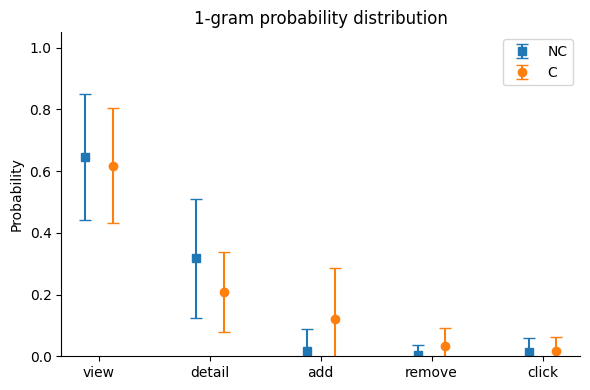

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create copy of features and labels
X_df = X_features.copy()
X_df['label'] = y

# Compute mean and std for each class
mean_df = X_df.groupby('label').mean()
std_df = X_df.groupby('label').std()

# Symbols (your columns in X_features)
symbols = ['P(1)', 'P(2)', 'P(3)', 'P(4)', 'P(6)']
symbol_labels = ['view', 'detail', 'add', 'remove', 'click']

# Plotting
x = np.arange(len(symbols))
width = 0.25

fig, ax = plt.subplots(figsize=(6, 4))

# Plot NC class
ax.errorbar(x - width/2, mean_df.loc[0, symbols], yerr=std_df.loc[0, symbols],
            fmt='s', capsize=4, label='NC', color='tab:blue')

# Plot C class
ax.errorbar(x + width/2, mean_df.loc[1, symbols], yerr=std_df.loc[1, symbols],
            fmt='o', capsize=4, label='C', color='tab:orange')

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(symbol_labels)
ax.set_ylabel('Probability')
ax.set_title('1-gram probability distribution')
ax.legend()
ax.set_ylim(0, 1.05)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

X-Axis: Click events

Y-Axis:\
The y-axis represents the probability or normalized frequency of that event occurring in a session. This is calculated as the number of occurrences of the symbol divided by the total number of events in the session. In the figure, the y-axis is labeled “Probability” because it shows these normalized values.

<b>What Are Error Bars and Their Use Here?</b> \
Error Bar Definition:\
An error bar is a graphical representation of the variability of data. In this case, the error bars indicate ± one standard deviation around the mean frequency calculated for each symbol. They give a visual clue about the spread or dispersion of the data points (i.e. how much individual session frequencies tend to deviate from the mean).

<b>Use in Figure 4: </b> \
By displaying error bars, the authors show that—even though you can compute an average frequency of, say, page views for conversion sessions versus non-conversion sessions, there is also a significant amount of variability. This variability suggests that the 1‑gram (or isolated event) statistics are not sufficiently different between C and NC classes to serve as a robust indicator on their own. Thus, while you see a mean value for each event type per class, the error bars (the standard deviation) underscore that the distributions largely overlap, implying that higher order interactions or more complex features (like 2‑grams or HVG motifs) might be necessary for effective classification.

<b>What the Figure Concludes About the Data?</b> \
<b>Main Result Displayed:</b> \
The figure shows that the relative abundances for each type of event (as captured by the 1‑gram probabilities) are quite similar between conversion (C) and non-conversion (NC) sessions when considering the standard deviation. In simpler terms, even though there are slight differences in the average probabilities between the classes, the high variability means that these features by themselves are not fully discriminative.

<b>Interpretation for Model Building:</b> \
Since the error bars indicate overlapping distributions between the two classes, the figure supports the assertion that more detailed (higher order) features—such as 2‑grams (pairs of consecutive events) or even combinatorial features like horizontal visibility graph motifs—are likely needed to capture subtle differences in user behavior that may predict conversion more reliably.

Figure 4 displays the mean normalized frequencies of 1-grams (individual symbols representing user actions) averaged over each class ensemble (conversion class C and non-conversion class NC) for trajectories with lengths between 5 and 155 clicks [24, Figure 4, 27]. The error bars in the figure indicate plus or minus one standard deviation


Simply looking at how often each individual action (symbol) appears in a user's browsing session is not enough on its own to reliably distinguish between users who will make a purchase (conversion class C) and those who will not (non-conversion class NC). Because of this, the study suggests that more complex patterns of actions (higher order statistics) need to be considered to improve the prediction of shopper intent (like 2-grams, which are sequences of two consecutive symbols) and horizontal visibility graph motifs (HVGm)

The figure demonstrates that when we look solely at the average frequency of individual actions, there isn't a clear separation between the conversion class (users who eventually purchase) and the non-conversion class (users who leave without purchasing). While there might be some slight visual differences in the mean frequencies of certain symbols between the two classes, the overlapping error bars suggest that these differences are not statistically significant enough to reliably predict whether a user will make a purchase based on the individual actions alone. Figure 5 further supports this by showing that the distributions of individual actions like 'view' (1), 'detail' (2), and 'add' (3) have comparable frequencies in both classes

#### Figure - 5

<b>What Figure 5 Represents?</b> \
<b>Purpose and Use:</b> \
Figure 5 plots the kernel density estimates (KDE) for three distinct 1‑gram features. The idea is to assess not just the average frequency (as in Figure 4) but to understand the distribution of these frequency estimates across all sessions. By comparing the density curves for the two classes—NC (non‑conversion) and C (conversion)—one can visually inspect whether the range, spread, or shape of these distributions differ between the classes. Such differences (or similarities) help in understanding which features might be more informative for distinguishing user behavior in conversion prediction.

<b>How It Is Used Here? </b>

- The KDE plots provide a smoothed estimate of the frequency distributions for each symbol.

- The code separates the data into two groups based on the “Class” column (mapped from the binary label 0 and 1).

- For each of the chosen features (P(view), P(detail), and P(add)), it plots the density curves for both C and NC sessions on the same subplot.

- This allows direct visual comparison to see if, for instance, one class consistently has a higher or differently shaped density for a given action.

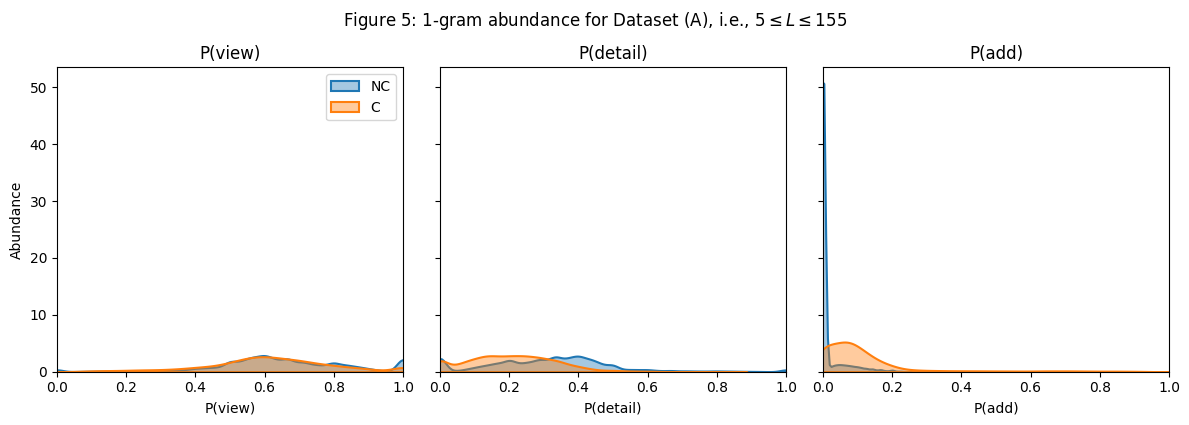

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
X_df = X_features.copy()
X_df['label'] = y
X_df['Class'] = X_df['label'].map({0: 'NC', 1: 'C'})

# Columns and titles
symbol_cols = {'P(1)': 'P(view)', 'P(2)': 'P(detail)', 'P(3)': 'P(add)'}
colors = {'NC': 'tab:blue', 'C': 'tab:orange'}

# Subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

for ax, (col, title) in zip(axes, symbol_cols.items()):
    for cls in ['NC', 'C']:
        sns.kdeplot(
            data=X_df[X_df['Class'] == cls],
            x=col,
            fill=True,
            alpha=0.4,
            linewidth=1.5,
            label=cls,
            ax=ax,
            color=colors[cls]
        )
    ax.set_title(title)
    ax.set_xlim(0, 1)
    ax.set_xlabel(title)
    ax.set_ylabel('Abundance')

# Add legend only once
axes[0].legend(title='')

# Tight layout and shared title
plt.tight_layout()
plt.suptitle('Figure 5: 1-gram abundance for Dataset (A), i.e., $5 \\leq L \\leq 155$', y=1.05)
plt.show()

<b>Explanation of the Axes and Results</b> \
X-Axis: \
The x-axis in each subplot represents the normalized frequency (or probability) of a particular event in a session. It ranges from 0 to 1 because the frequency is computed as the count of occurrences of that event divided by the total number of events in the session.

Y-Axis: \
The y-axis represents the estimated density (or abundance) of sessions at a given frequency value. It is not the absolute count, but rather a density measure obtained from the KDE algorithm. Higher values mean that more sessions have that specific frequency for the event.

<b>Result and Interpretation:</b> \

- For each event type (view, detail, and add), you see separate curves for the NC and C classes.

- The curves allow you to identify whether there is a statistically significant difference in how frequently each action appears in sessions that convert versus those that do not.

- If the densities largely overlap (or have similar shapes), it indicates that the individual event frequency (1‑gram) might not be very discriminative by itself.

- Conversely, if one class shows a curve that is shifted or has a noticeably different spread, it suggests that the event frequency might be an informative feature for conversion prediction.

Figure - 5 shows the distribution of how frequently a particular symbol appears in trajectories belonging to either the conversion class (C) or the non-conversion class (NC). The curves in each panel represent the number of trajectories within each class that display a certain normalized frequency (P(s)) of the respective 1-gram

- Abundance: relative density of p(s) - Kernel Density Estimation derived probability density (A large number of NC sessions (non-converting users) have P(add) ≈ 0)

- Comparable Distributions Across Classes: The overlap in the distributions for each action suggests that simply knowing how often a user views a page, looks at product details, or adds items to their cart is not enough to reliably predict whether they will eventually make a purchase

- 'Add' Action as a Potentially Informative Feature: While the distributions are comparable, the text notes that the 'add' action (P(3)) is more abundant in trajectories belonging to the conversion (C) class. This is more evident in the right panel. The distribution for class C for P(add) tends to be shifted slightly towards higher frequencies compared to class NC. This makes intuitive sense as adding a product to the cart is a prerequisite for buying. Therefore, the frequency of the 'add' action might be a more informative individual feature compared to 'view' or 'detail', although still not fully discriminative on its own

### Trejectory length Fig 8 (b)

Creates histograms for both classes using the same set of bins (from 5 to 155). The density=True option normalizes the histograms, so the y-axis represents a probability density rather than raw counts.

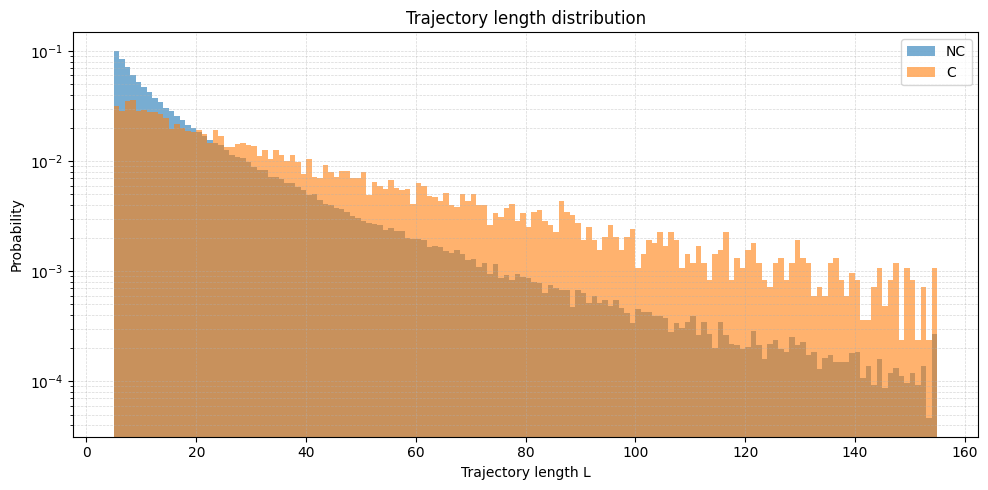

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate lengths of each sequence
lengths = [len(seq) for seq in sequences]
labels_np = np.array(labels)  # Convert to NumPy array for indexing

# Separate lengths by class
nc_lengths = [lengths[i] for i in range(len(lengths)) if labels[i] == 0]
c_lengths  = [lengths[i] for i in range(len(lengths)) if labels[i] == 1]

# Plotting
plt.figure(figsize=(10, 5))
bins = np.arange(5, 156)  # As specified: 5 ≤ L ≤ 155

plt.hist(nc_lengths, bins=bins, density=True, alpha=0.6, color='tab:blue', label='NC')
plt.hist(c_lengths, bins=bins, density=True, alpha=0.6, color='tab:orange', label='C')

plt.yscale('log')
plt.xlabel('Trajectory length L')
plt.ylabel('Probability')
plt.title('Trajectory length distribution')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.show()


X axis: 5 <= L <= 155 \
Y axis: probability densities across a wide range of session frequencies

Log Scale on the Y-Axis: \
By using a logarithmic scale on the y-axis, the plot makes it easier to view and compare the probability densities across a wide range of session frequencies—especially when the counts span several orders of magnitude.

<b>Broad and Overlapping Distributions:</b> \

Both conversion and non‑conversion sessions span a wide range of trajectory lengths. The distributions are broad, indicating that users exhibit diverse browsing durations in both classes.

There is considerable overlap between the two distributions, which suggests that, on average, the raw session length by itself might not be a strong discriminative feature for predicting conversion.

<b>Differences in the Short-Trajectory Regime: </b> \

The figure shows a relatively higher density of very short trajectories (closer to L = 5) in the NC class. In other words, non‑conversion sessions tend to be overrepresented among the shorter sessions.

Despite conversion sessions being trimmed (i.e., removing the purchase event), they tend to have slightly longer lengths overall compared to the NC sessions. This indicates that users who eventually convert may generally have more extended browsing sessions than those who do not convert.

<b>Implications for Predictive Modeling: </b>

Since both classes contain trajectories of many different lengths and with significant overlap, trajectory length on its own is unlikely to be a decisive predictor of conversion.

The observed trend (more short sessions in NC) supports the idea that while session length might contribute some information, more nuanced features (such as higher‐order interactions from 2‑grams or visibility graph motifs) are likely necessary to improve predictive performance.


- The distributions of trajectory lengths for the two classes (C and NC) are rather broad and significantly overlap. This overlap makes the mean trajectory length likely not a very effective single feature for distinguishing between purchasing and non-purchasing customers.

- Interestingly, the authors noted that there are more short trajectories belonging to the NC class compared to the C class, even after the C class trajectories were trimmed to exclude the purchase event itself. This suggests that very short sessions are more likely to end without a purchase.

### Training and Evaluating Feature-Based Models

### 1. Classification using hand crafted features

In [34]:
from sklearn.model_selection import train_test_split

# Convert features and labels to numpy for modeling
X = X_features.values
y_arr = y.values

# Separate conversion and non-conversion indices for stratified sampling
conv_indices = [i for i, lbl in enumerate(y_arr) if lbl == 1]
nc_indices = [i for i, lbl in enumerate(y_arr) if lbl == 0]

# Shuffle the indices
import numpy as np
np.random.shuffle(conv_indices)
np.random.shuffle(nc_indices)

# Determine split sizes
num_conv = len(conv_indices)
train_size = int(0.70 * num_conv)
val_size = int(0.15 * num_conv)
test_size = num_conv - train_size - val_size

# Select conversion subsets
train_conv_idx = conv_indices[:train_size]
val_conv_idx   = conv_indices[train_size: train_size+val_size]
test_conv_idx  = conv_indices[train_size+val_size:]

# Select non-conversions equal in count to conversions for each set
train_nc_idx = nc_indices[:train_size]
val_nc_idx   = nc_indices[train_size: train_size+val_size]
test_nc_idx  = nc_indices[train_size+val_size: train_size+val_size+test_size]

# Combine conversion + non-conversion indices for each set
train_idx = np.array(train_conv_idx + train_nc_idx)
val_idx   = np.array(val_conv_idx + val_nc_idx)
test_idx  = np.array(test_conv_idx + test_nc_idx)

# Shuffle each combined set (so classes are mixed)
np.random.shuffle(train_idx)
np.random.shuffle(val_idx)
np.random.shuffle(test_idx)

# Create train/val/test splits
X_train, y_train = X[train_idx], y_arr[train_idx]
X_val, y_val     = X[val_idx], y_arr[val_idx]
X_test, y_test   = X[test_idx], y_arr[test_idx]

print("Train set size:", len(X_train), "positive:", sum(y_train), "negative:", len(y_train)-sum(y_train))
print("Test set size:", len(X_test), "positive:", sum(y_test), "negative:", len(y_test)-sum(y_test))


Train set size: 11660 positive: 5830 negative: 5830
Test set size: 2500 positive: 1250 negative: 1250


In [35]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, classification_report

In [36]:
# Train XGBoost model (with default hyperparameters or tuned if desired)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Evaluate on test set
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]  # probability of class 1 (conversion)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test F1-score:", f1_score(y_test, y_pred))
print("Test ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:06:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Accuracy: 0.87
Test F1-score: 0.8687928946306015
Test ROC AUC: 0.93262528

Classification Report:
               precision    recall  f1-score   support

           0     0.8633    0.8792    0.8712      1250
           1     0.8769    0.8608    0.8688      1250

    accuracy                         0.8700      2500
   macro avg     0.8701    0.8700    0.8700      2500
weighted avg     0.8701    0.8700    0.8700      2500



### 1.2 Feature Importance

In [ ]:
from sklearn.inspection import permutation_importance
# Compute permutation importance on the validation set (or test set)
perm_result = permutation_importance(xgb_model, X_val, y_val, n_repeats=5, scoring='f1', random_state=0)
importances = perm_result.importances_mean  # average importance score for each feature
# Get feature importances in the original feature order (1-grams, 2-grams, motifs)
for name, imp in zip(feature_names, importances):
    print(f"{name}: {imp:.4f}")

P(1): 0.0092
P(2): 0.0134
P(3): 0.0782
P(4): 0.0318
P(6): 0.0007
P(1,1): 0.0284
P(1,2): 0.2115
P(1,3): 0.0009
P(1,4): 0.0010
P(1,6): 0.0010
P(2,1): 0.0296
P(2,2): 0.0046
P(2,3): 0.0050
P(2,4): 0.0003
P(2,6): 0.0004
P(3,1): 0.1209
P(3,2): 0.0020
P(3,3): 0.0001
P(3,4): 0.0001
P(3,6): 0.0000
P(4,1): 0.0007
P(4,2): -0.0001
P(4,3): 0.0000
P(4,4): 0.0003
P(4,6): 0.0000
P(6,1): 0.0020
P(6,2): -0.0005
P(6,3): 0.0009
P(6,4): 0.0000
P(6,6): 0.0000
Z1: 0.0095
Z2: 0.0203
Z3: 0.0059
Z4: 0.0030
Z5: 0.0012
Z6: 0.0007
h_z: 0.0143


#### Figure - 9

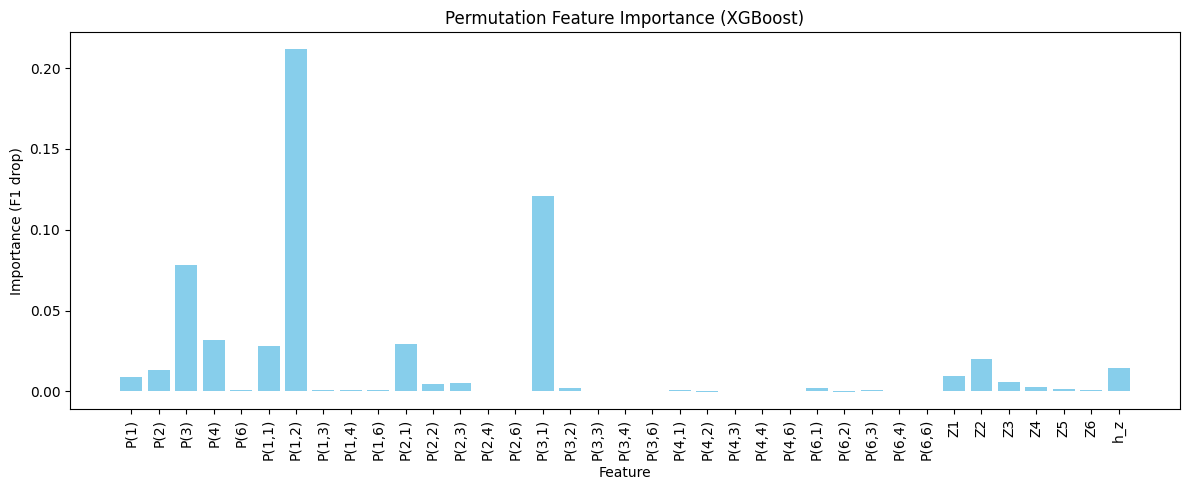

In [ ]:
import matplotlib.pyplot as plt

# Plot feature importances in the grouped order (1g, 2g, HVG)
plt.figure(figsize=(12,5))
plt.bar(range(len(importances)), importances, color='skyblue')
plt.xticks(range(len(importances)), feature_names, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance (F1 drop)')
plt.title('Permutation Feature Importance (XGBoost)')
plt.tight_layout()
plt.show()

X-axis: Feature \

Y-axis: Importance (F1 drop) \
This axis represents how important each feature is to the model's performance, measured by:

The drop in F1 score when the feature is randomly permuted

So, larger values mean: \
- The feature had a big impact on the F1 score
- Randomizing it caused the model to perform worse → it’s important

Smaller values mean: \
- The model performance didn’t change much when that feature was shuffled → less important

<b>Figure 9 – Permutation Feature Importance (XGBoost)</b>

According to the authors' interpretation of Figure 9:

- They initially expected the presence of the 'add' action (symbol 3), represented by P(3), to be highly significant, as adding a product to the cart is a precursor to buying.

- However, they found that the combination of 'add-view' actions (P(3, 1)) was more relevant than the isolated 'add' action.

- More surprisingly, even this was not the most relevant feature. The web exploration patterns, related to 'view' (symbol 1) and 'detail' (symbol 2) actions, provided the most important information. This is supported by the importance of some HVGms, suggesting that these navigation patterns are indeed quite informative.

- This is significant because the trajectories are mostly composed of 'view' and 'detail' actions, indicating that users frequently navigate between pages (series of 'view'), products (series of 'detail'), and from pages to products ('view-detail' or 'detail-view').

- They rarely go directly to a specific product from a search result ('click', symbol 6).

#### Figure - 10 SHapley Additive exPlanations

 In order to dive deeper into the analysis, we use SHAP’s tree interpreter to see the effect of each feature in the prediction.

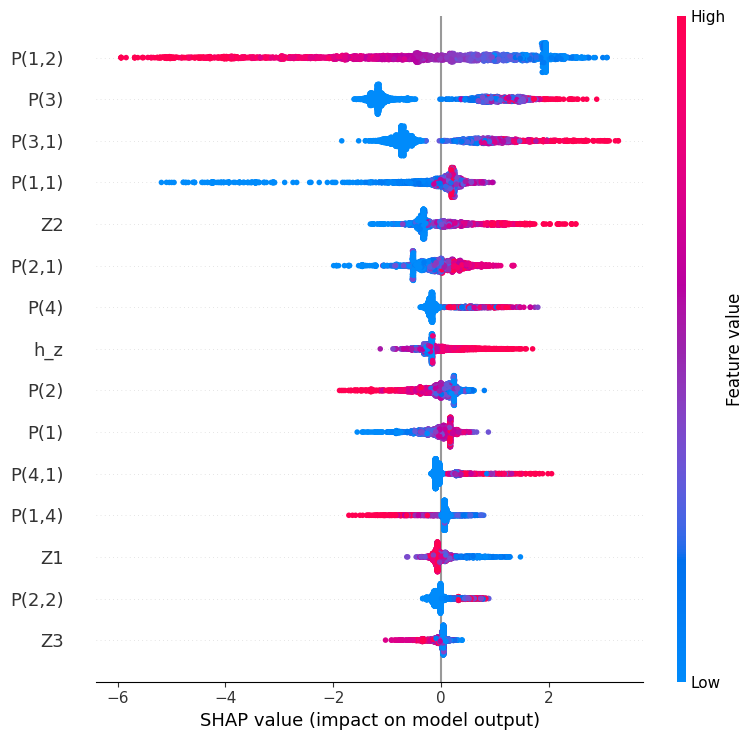

In [38]:
import shap
import matplotlib.pyplot as plt

# Initialize JS visualization (optional for Jupyter environments)
shap.initjs()

# Create a SHAP TreeExplainer using your trained XGBoost model
explainer = shap.TreeExplainer(xgb_model)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Produce a summary (beeswarm) plot of the SHAP values for the top 15 features.
# This plot shows, for each feature, dots representing the SHAP value (x-axis) for each sample.
# Color indicates the original value of the feature.
shap.summary_plot(
    shap_values,
    X_test,
    feature_names=feature_names,
    max_display=15,  # display top 15 features
    plot_type="dot"
)

<b>Interpretation of the Plot</b>

Y-axis: Top 15 features ranked by importance (from most to least impactful).

X-axis: SHAP value — how much a feature pushes the prediction toward purchase (C) (right side) or non-conversion (NC) (left side).

Color of dots: Indicates the feature's value for that sample — from low (blue) to high (red).

Each dot = one session.

<b>Authors’ Main Observations and Conclusions</b> \

1. Most Predictive Feature (P(1,2)) Indicates Non-Purchase

- The most important feature is P(1,2) (view → detail transitions).

- High values (red dots far left) strongly indicate non-conversion.

- These users explore many products but don't act (i.e., casual browsing)​.

2. Non-converting Patterns \

- High P(1,1) (view → view) and P(2) (detail page visits), but low P(2,2) (detail → detail).

- High P(6) (click events) — suggest wandering behavior with low purchase intent.

- High values of motif Z1 and low entropy h_z → monotonic, repetitive patterns – "browsing without purpose".

3. Converting Patterns \

- High P(1) (views), combined with transitions from varied previous states: P(2,1) (detail → view), P(3,1) (add → view).

- High P(2,2) (detail → detail) → focused comparison of products, suggesting more intentional exploration.

- High HVGm entropy h_z → richer, more varied navigation — a sign of goal-driven behavior​.

4. Example Trajectories \

- Non-conversion: Repetitive browsing (e.g., 111212) → results in high P(1,2) and Z1 only, indicating dull pattern.

- Conversion: Structured browsing like 132131 → includes add/view/detail diversity, motifs Z1, Z3, Z5, and high h_z.



### 2. From hand‑crafted to automatic feature extraction using neural networks

#### 2.1 Deep Learning Model (LSTM Sequence Classification)

In [39]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Prepare sequence data for PyTorch (use the same train/val/test split indices derived earlier)
train_sequences = [sequences[i] for i in train_idx]
train_labels = [labels[i] for i in train_idx]
val_sequences = [sequences[i] for i in val_idx]
val_labels = [labels[i] for i in val_idx]
test_sequences = [sequences[i] for i in test_idx]
test_labels = [labels[i] for i in test_idx]

# Define an LSTM classifier model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, pooling='last'):
        super(LSTMClassifier, self).__init__()
        self.pooling = pooling
        # Embedding layer to encode symbols (vocab: 0 for PAD, 1-6 for actual symbols)
        self.embed = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x, lengths):
        # x: tensor of shape (batch, seq_len) with padded sequences
        # lengths: tensor of actual lengths for each sequence in the batch
        embedded = self.embed(x)  # (batch, seq_len, embed_dim)
        # Pack the sequence for LSTM to ignore pads
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, (h_n, c_n) = self.lstm(packed)
        if self.pooling == 'last':
            # h_n contains the final hidden state for each sequence (shape: [1, batch, hidden_size] for 1-layer LSTM)
            last_hidden = h_n[-1]   # (batch, hidden_size)
            out = self.fc(last_hidden)  # (batch, 1)
        elif self.pooling == 'avg':
            # Pad back to get LSTM outputs for each time step
            lstm_out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True, total_length=x.size(1))
            # Compute average of outputs for each sequence (excluding pads)
            # Sum along time dimension and divide by length (lengths are broadcastable after unsqueeze)
            sum_out = torch.sum(lstm_out, dim=1)  # (batch, hidden_size)
            avg_out = sum_out / lengths.unsqueeze(1)  # divide each vector by its sequence length
            out = self.fc(avg_out)  # (batch, 1)
        else:
            raise ValueError("Pooling must be 'last' or 'avg'")
        return out  # raw logits

# Dataset class for sequences
class SequenceDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Collate function to pad sequences in a batch
def collate_fn(batch):
    # batch is a list of (sequence, label) tuples
    batch_seqs = [torch.tensor(seq, dtype=torch.long) for seq, lbl in batch]
    batch_labels = torch.tensor([lbl for seq, lbl in batch], dtype=torch.float32)
    # Pad sequences to the same length
    lengths = torch.tensor([len(seq) for seq in batch_seqs], dtype=torch.long)
    padded_seqs = nn.utils.rnn.pad_sequence(batch_seqs, batch_first=True, padding_value=0)
    # Note: We use 0 as PAD index (not used in actual symbol set 1-6)
    return padded_seqs, lengths, batch_labels

# Create DataLoaders for train, val, test
train_dataset = SequenceDataset(train_sequences, train_labels)
val_dataset   = SequenceDataset(val_sequences, val_labels)
test_dataset  = SequenceDataset(test_sequences, test_labels)
batch_size = 16  # as per best hyperparams&#8203;:contentReference[oaicite:43]{index=43}
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Initialize the LSTM model
vocab_size = 1 + 6  # 0 (PAD) + symbols 1-6
hidden_size = 32    # using best found for S2L-last&#8203;:contentReference[oaicite:44]{index=44}
embed_dim = 16      # embedding dimension (can be equal to hidden or smaller; 16 is chosen here)
model = LSTMClassifier(vocab_size=vocab_size, embed_dim=embed_dim, hidden_size=hidden_size, pooling='last')
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # best LR for last pooling&#8203;:contentReference[oaicite:45]{index=45}

# Training loop with early stopping
epochs = 50
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(1, epochs+1):
    model.train()
    total_loss = 0.0
    for X_batch, lengths, y_batch in train_loader:
        optimizer.zero_grad()
        logits = model(X_batch, lengths)
        loss = criterion(logits.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, lengths, y_batch in val_loader:
            logits = model(X_batch, lengths)
            loss = criterion(logits.squeeze(), y_batch)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch}: train_loss={avg_train_loss:.4f}, val_loss={avg_val_loss:.4f}")

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()  # save best model parameters
    else:
        epochs_no_improve += 1
    if epochs_no_improve >= patience:
        print("Early stopping triggered.")
        break

# Load best model weights
model.load_state_dict(best_model_state)

Epoch 1: train_loss=0.3243, val_loss=0.2512
Epoch 2: train_loss=0.2354, val_loss=0.2352
Epoch 3: train_loss=0.2252, val_loss=0.2330
Epoch 4: train_loss=0.2214, val_loss=0.2227
Epoch 5: train_loss=0.2189, val_loss=0.2207
Epoch 6: train_loss=0.2168, val_loss=0.2343
Epoch 7: train_loss=0.2162, val_loss=0.2188
Epoch 8: train_loss=0.2140, val_loss=0.2187
Epoch 9: train_loss=0.2168, val_loss=0.2194
Epoch 10: train_loss=0.2129, val_loss=0.2186
Epoch 11: train_loss=0.2137, val_loss=0.2205
Epoch 12: train_loss=0.2116, val_loss=0.2196
Epoch 13: train_loss=0.2110, val_loss=0.2206
Epoch 14: train_loss=0.2103, val_loss=0.2171
Epoch 15: train_loss=0.2094, val_loss=0.2181
Epoch 16: train_loss=0.2081, val_loss=0.2182
Epoch 17: train_loss=0.2083, val_loss=0.2190
Epoch 18: train_loss=0.2067, val_loss=0.2186
Epoch 19: train_loss=0.2053, val_loss=0.2214
Early stopping triggered.


<All keys matched successfully>

In [40]:
model.eval()
y_pred = []
y_scores = []
with torch.no_grad():
    for X_batch, lengths, y_batch in test_loader:
        logits = model(X_batch, lengths)
        prob = torch.sigmoid(logits).squeeze()  # convert logits to probability
        # Predicted label (0 or 1) using 0.5 threshold
        pred = (prob >= 0.5).long()
        y_pred.extend(pred.tolist())
        y_scores.extend(prob.tolist())

y_test_true = np.array(test_labels)
y_test_pred = np.array(y_pred)
y_test_proba = np.array(y_scores)
print("LSTM Test F1-score:", f1_score(y_test_true, y_test_pred))
print("LSTM Test ROC AUC:", roc_auc_score(y_test_true, y_test_proba))
print("\nClassification Report:\n", classification_report(y_test_true, y_test_pred, digits=4))

LSTM Test F1-score: 0.9084096586178185
LSTM Test ROC AUC: 0.96848992

Classification Report:
               precision    recall  f1-score   support

           0     0.8820    0.9512    0.9153      1250
           1     0.9470    0.8728    0.9084      1250

    accuracy                         0.9120      2500
   macro avg     0.9145    0.9120    0.9119      2500
weighted avg     0.9145    0.9120    0.9119      2500



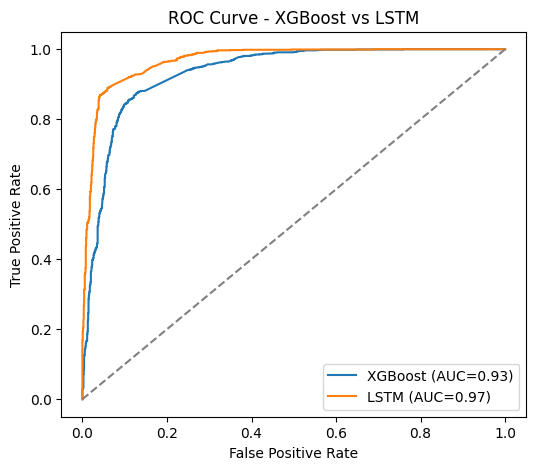

In [41]:
from sklearn.metrics import roc_curve

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba)   # XGBoost
fpr_lstm, tpr_lstm, _ = roc_curve(y_test_true, y_test_proba)  # LSTM

plt.figure(figsize=(6,5))
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC={roc_auc_score(y_test, y_proba):.2f})")
plt.plot(fpr_lstm, tpr_lstm, label=f"LSTM (AUC={roc_auc_score(y_test_true, y_test_proba):.2f})")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost vs LSTM")
plt.legend()
plt.show()

<b>Key Metrics Comparison</b>

Metric	XGBoost	LSTM \
Accuracy \
87.0%	91.2%	LSTM is more accurate overall

F1-score \
0.869 (avg)	0.912	LSTM handles class balance and precision/recall better

ROC AUC \
0.93	0.97	LSTM distinguishes positives vs. negatives better

<b>What Does the ROC Curve Show?</b>

The ROC curve (Receiver Operating Characteristic) is a plot that shows how well a binary classifier separates the two classes.

Higher AUC means better ability to distinguish between positive and negative classes.

Your ROC plot shows: \

- True Positive Rate (TPR) on Y-axis

- False Positive Rate (FPR) on X-axis

Each curve shows how well the classifier separates the two classes as the decision threshold changes. \

Interpretation: \

- The closer the curve is to the top-left, the better the classifier.

- LSTM curve is higher than XGBoost → It has a higher AUC (0.97), which means:

- LSTM is better at ranking positive examples higher than negatives

- The diagonal dashed line represents random guessing (AUC = 0.5)

### Why we used Handcrafted Features + XGBoost?

The authors deliberately used handcrafted symbolic features (like k-grams and HVG motifs) with XGBoost and shallow NNs for three main reasons:

Interpretability \

- These features (like P(1,2), Z1, etc.) allow clear interpretation of user behavior patterns (e.g., users who just view and never add → likely non-converters).

- This helps understand what the model is learning, which is hard with deep models​.

Computational Efficiency \

- XGBoost is faster to train, has fewer hyperparameters, and doesn’t require GPUs.
- Useful for real-time applications or companies with limited infrastructure​.

Strong Baselines \

- Despite their simplicity, handcrafted models perform very well — sometimes outperforming deep models under:

- Short sequences (early prediction)

- Class imbalance

- Low-resource settings​


<table border="1" cellspacing="0" cellpadding="6">
  <thead>
    <tr>
      <th>Aspect</th>
      <th>Handcrafted + XGBoost</th>
      <th>Deep Learning (LSTM)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Accuracy (full seq)</td>
      <td>High, but slightly lower than LSTM</td>
      <td>Highest overall accuracy</td>
    </tr>
    <tr>
      <td>Early Prediction</td>
      <td>Often better performance for limited sequence windows</td>
      <td>May struggle if trained solely on full sequences</td>
    </tr>
    <tr>
      <td>Interpretability</td>
      <td>&#10004; Excellent – features (k‑grams, HVG motifs) are clear and explainable</td>
      <td>&#10008; Harder to interpret due to black-box nature</td>
    </tr>
    <tr>
      <td>Infrastructure Cost</td>
      <td>&#10004; Low computational cost, easier to deploy</td>
      <td>&#10008; High cost (requires GPU and longer training time)</td>
    </tr>
    <tr>
      <td>Suitability</td>
      <td>Ideal for lightweight, fast pipelines with robust baselines</td>
      <td>Suitable for capturing rich behavioral patterns with higher accuracy</td>
    </tr>
    <tr>
      <td>Author Opinion</td>
      <td>Valuable, robust, scalable baseline method</td>
      <td>Best for maximizing accuracy, though costlier and more complex to deploy</td>
    </tr>
  </tbody>
</table>
